"""
Baseline Phase: Noiseless Hybrid Quantum Control

Objective: Train a classical neural network (Controller) to output parameters
           for a quantum circuit (Controlled PQC) to steer a single qubit to
           target states (|0⟩ or |1⟩), compensating for a fixed, unknown
           (to the NN) miscalibration, in a noiseless simulation environment.
"""

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
!pip install tensorflow-quantum==0.7.3

In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources

importlib.reload(pkg_resources)

<ipython-input-3-ab1b6a95bcd9>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import importlib, pkg_resources


<module 'pkg_resources' from '/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py'>

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Quantum version:", tfq.__version__)
print("Cirq version:", cirq.__version__)

TensorFlow version: 2.15.0
TensorFlow Quantum version: 0.7.2
Cirq version: 1.3.0


In [ ]:
# --- Qubit Definition ---
# We'll use a single qubit for this control task.
qubit = cirq.GridQubit(0, 0)
print(f"Qubit defined: {qubit}")

Qubit defined: q(0, 0)


In [ ]:
# --- Miscalibration Circuit (Systematic Error) ---
# This represents a fixed, unknown error that happens *before* our control.
# We generate random angles ONCE and keep them fixed throughout the experiment.
# Small angles simulate a slight miscalibration.
miscalibration_angles = np.random.uniform(0, 0.4, 3) # Small fixed errors
miscalibration_circuit = cirq.Circuit(
    cirq.rx(miscalibration_angles[0])(qubit),
    cirq.ry(miscalibration_angles[1])(qubit),
    cirq.rz(miscalibration_angles[2])(qubit)
)
print("\nFixed Miscalibration Circuit (Systematic Error):")
print(miscalibration_circuit)


Fixed Miscalibration Circuit (Systematic Error):
(0, 0): ───Rx(0.01π)───Ry(0.042π)───Rz(0.023π)───


In [ ]:
# --- Controlled Circuit (Parameterized Quantum Circuit - PQC) ---
# This is the circuit whose parameters the classical NN will learn to control.
# We use sympy symbols as placeholders for the parameters.
control_params_sym = sympy.symbols('theta_1 theta_2 theta_3')
controlled_circuit = cirq.Circuit(
    cirq.rz(control_params_sym[0])(qubit),
    cirq.ry(control_params_sym[1])(qubit),
    cirq.rx(control_params_sym[2])(qubit)
)
print("\nControlled PQC (Parameters to be learned by NN):")
print(controlled_circuit)


Controlled PQC (Parameters to be learned by NN):
(0, 0): ───Rz(theta_1)───Ry(theta_2)───Rx(theta_3)───


In [ ]:
# --- Readout Observable ---
# We want to steer the qubit towards |0⟩ or |1⟩, which are eigenstates of Z.
# So, we measure the expectation value of the Z operator.
readout_op = cirq.Z(qubit)
print(f"\nReadout Observable: {readout_op}")


Readout Observable: Z(q(0, 0))


In [ ]:
# --- Define Classical Controller ---(Neural Network)

# --- Controller Model (Keras Sequential) ---
# This simple NN takes a classical command (0 or 1) and outputs the 3
# parameters (theta_1, theta_2, theta_3) for the controlled PQC.
# Input: Shape (1,) representing the command.
# Output: Shape (3,) representing the gate parameters.
controller_nn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.float32),
    tf.keras.layers.Dense(10, activation='elu'), # Hidden layer
    tf.keras.layers.Dense(3) # Output layer for 3 parameters
])

In [ ]:
print("\nClassical Controller NN Summary:")
controller_nn.summary()


Classical Controller NN Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 53 (212.00 Byte)
Trainable params: 53 (212.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 3. Build the Hybrid Quantum-Classical Model (TFQ/Keras)

# --- Define Keras Inputs ---
# Input for the base quantum circuits (containing the miscalibration).
# It takes serialized Cirq circuits as strings.
base_circuits_input = tf.keras.Input(shape=(), dtype=tf.string, name='base_circuits')

# Input for the classical commands (0 or 1).
commands_input = tf.keras.Input(shape=(1,), dtype=tf.float32, name='commands')

# --- Connect Controller to Commands ---
# The classical NN processes the command input to generate gate parameters.
controller_output = controller_nn(commands_input)

In [ ]:
# --- Define the TFQ Layer (ControlledPQC) ---
# This layer connects the classical controller to the quantum circuit.
# It takes:
#   1. The parameterized quantum circuit (controlled_circuit).
#   2. The measurement operators (readout_op).
# It expects inputs:
#   [base_circuits, parameters_for_controlled_circuit]
# In this baseline, we use the default 'noiseless' analytical backend.
expectation_layer = tfq.layers.ControlledPQC(
    controlled_circuit,
    operators=readout_op,
    name='controlled_pqc'
    # backend='noiseless' is the default
)

# --- Link Inputs and Layers ---
# The ControlledPQC layer takes the base circuits and the parameters from the NN.
expectation_output = expectation_layer([base_circuits_input, controller_output])

In [ ]:
# --- Build the Full Keras Model ---
# Define the inputs and output of the complete hybrid model.
hybrid_model = tf.keras.Model(
    inputs=[base_circuits_input, commands_input],
    outputs=expectation_output,
    name='hybrid_quantum_control_model'
)


Full Hybrid Model Architecture:
Model: "hybrid_quantum_control_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 commands (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 base_circuits (InputLayer)  [(None,)]                    0         []                            
                                                                                                  
 sequential (Sequential)     (None, 3)                    53        ['commands[0][0]']            
                                                                                                  
 controlled_pqc (Controlled  (None, 1)                    0         ['base_circuits[0][0]',       
 PQC)                                 

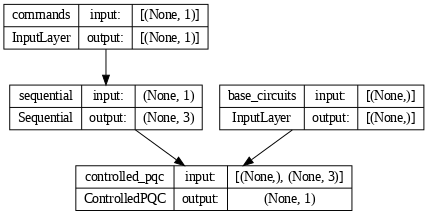

In [ ]:
print("\nFull Hybrid Model Architecture:")
hybrid_model.summary()
tf.keras.utils.plot_model(hybrid_model, show_shapes=True, dpi=70)

In [ ]:
# %% 4. Prepare Dataset for Training

# --- Classical Commands ---
# Command 0 aims for |0⟩ state (Z expectation +1)
# Command 1 aims for |1⟩ state (Z expectation -1)
commands_data = np.array([[0.], [1.]], dtype=np.float32)
print(f"\nClassical Commands:\n{commands_data}")


Classical Commands:
[[0.]
 [1.]]


In [ ]:
# --- Target Quantum States (Expectation Values) ---
expected_outputs_data = np.array([[1.], [-1.]], dtype=np.float32)
print(f"\nTarget Expectation Values:\n{expected_outputs_data}")


Target Expectation Values:
[[ 1.]
 [-1.]]


In [ ]:
# --- Base Quantum Circuits (Miscalibration) ---
# We need two copies of the *same* miscalibration circuit, one for each command.
# The ControlledPQC layer will append the parameterized controlled_circuit
# with parameters determined by the controller_nn based on the command.
base_circuits_tensor = tfq.convert_to_tensor([miscalibration_circuit] * 2)# We need two because we have two different control commands (0 and 1) we want to apply
print(f"\nBase Circuits Tensor Shape: {base_circuits_tensor.shape}")
# You can optionally print the content if needed, but it's a serialized string.
# print(base_circuits_tensor.numpy())


Base Circuits Tensor Shape: (2,)


In [ ]:
# --- Combine into TensorFlow Dataset (Optional) ---
# For this simple 2-point dataset, direct feeding is okay, but a tf.data.Dataset
# is more standard for larger datasets.
# train_dataset = tf.data.Dataset.from_tensor_slices(
#     ((base_circuits_tensor, commands_data), expected_outputs_data)
# )
# train_dataset = train_dataset.batch(2) # Process both points at once

In [ ]:
# 5. Compile and Train the Model (Noiseless Baseline)

# --- Compile ---
# We use Mean Squared Error because we are trying to match the target
# expectation values (+1 or -1).
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss_fn = tf.keras.losses.MeanSquaredError()
hybrid_model.compile(optimizer=optimizer, loss=loss_fn)
print("\nModel Compiled Successfully!")


Model Compiled Successfully!


In [ ]:
# --- Train ---
# Train the model. The controller_nn's weights will be updated to minimize
# the difference between the quantum circuit's output expectation and the target.
EPOCHS = 100
Train = hybrid_model.fit(
    x=[base_circuits_tensor, commands_data], # Input circuits and commands
    y=expected_outputs_data,                # Target expectation values
    epochs=EPOCHS,
    verbose=0 # Set to 1 to see epoch details
)

print(f"\nTraining Complete after {EPOCHS} epochs.")


Training Complete after 100 epochs.


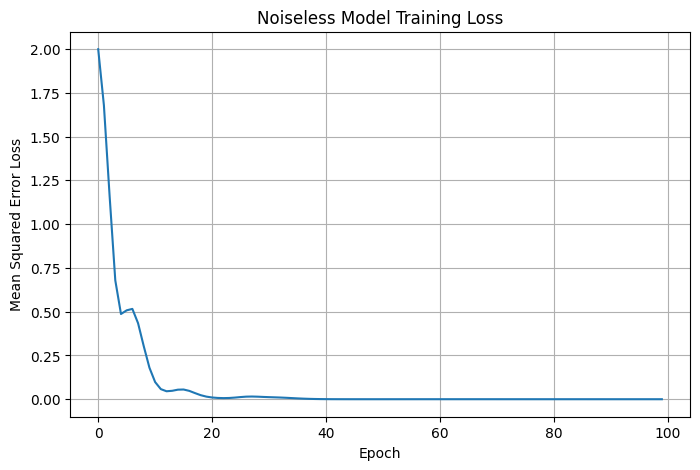

In [ ]:
# 6. Evaluate the Baseline Model

# --- Plot Loss ---
plt.figure(figsize=(8, 5))
plt.plot(Train.history['loss'])
plt.title("Noiseless Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error Loss")
plt.grid(True)
plt.show()

In [ ]:
# --- Check Final Performance ---
# Use the trained model to predict the expectation values for the commands.
final_expectations = hybrid_model.predict([base_circuits_tensor, commands_data])
print("\n--- Baseline Model Evaluation ---")
print(f"Target output for command 0 (|0⟩ state): {expected_outputs_data[0,0]:.4f}")
print(f"Achieved output for command 0: {final_expectations[0,0]:.4f}")
print(f"Target output for command 1 (|1⟩ state): {expected_outputs_data[1,0]:.4f}")
print(f"Achieved output for command 1: {final_expectations[1,0]:.4f}")

1/1 [==============================] - 0s 144ms/step

--- Baseline Model Evaluation ---
Target output for command 0 (|0⟩ state): 1.0000
Achieved output for command 0: 0.9956
Target output for command 1 (|1⟩ state): -1.0000
Achieved output for command 1: -0.9960


In [ ]:
final_loss = history.history['loss'][-1]
print(f"\nFinal Training Loss: {final_loss:.6f}")
if final_loss < 1e-3:
    print("\nThe model successfully learned to correct the miscalibration in the noiseless case!")
else:
    print("\nThe model did not fully converge. Consider increasing epochs or adjusting learning rate.")


Final Training Loss: 0.000019

The model successfully learned to correct the miscalibration in the noiseless case!


In [ ]:
# --- (Optional) Verification with Cirq Simulator ---
# Get the learned parameters from the controller
learned_params_batch = controller_nn(commands_data).numpy()

# Simulate using Cirq to double-check
cirq_simulator = cirq.Simulator()
print("\n--- Verification with Cirq ---")
for i, command in enumerate(commands_data):
    params_for_command = learned_params_batch[i]
    resolver = cirq.ParamResolver({
        symbol: val for symbol, val in zip(control_params_sym, params_for_command)
    })
    # Create the full circuit for this command's parameters
    full_resolved_circuit = miscalibration_circuit + cirq.resolve_parameters(controlled_circuit, resolver)
    # Simulate
    final_state_vector = cirq_simulator.simulate(full_resolved_circuit).final_state_vector
    # Calculate expectation
    cirq_expectation = readout_op.expectation_from_state_vector(final_state_vector, {qubit: 0}).real

    print(f"Command {int(command[0])}: Target={expected_outputs_data[i,0]:.4f}, TFQ Model Output={final_expectations[i,0]:.4f}, Cirq Sim Output={cirq_expectation:.4f}")


--- Verification with Cirq ---
Command 0: Target=1.0000, TFQ Model Output=0.9956, Cirq Sim Output=0.9956
Command 1: Target=-1.0000, TFQ Model Output=-0.9960, Cirq Sim Output=-0.9960
